hilbert reference: https://github.com/galtay/hilbertcurve/blob/main/hilbertcurve/hilbertcurve.py

In [1]:
%load_ext lab_black
%cd ..

/root/data2/jaehyeok/dev/ddpm/space-filling-pytorch


In [2]:
import numpy as np
import torch as th

from hilbertcurve.hilbertcurve import HilbertCurve

In [3]:
th.cuda.set_device(9)

In [4]:
hc = HilbertCurve(p=16, n=3)

---

In [8]:
import torch as th
import triton
import triton.language as tl
from torch import Tensor


# @triton.autotune(
#     configs=[
#         triton.Config({"BLOCK_SIZE": 32}),
#         triton.Config({"BLOCK_SIZE": 64}),
#         triton.Config({"BLOCK_SIZE": 128}),
#         triton.Config({"BLOCK_SIZE": 256}),
#         triton.Config({"BLOCK_SIZE": 512}),
#         triton.Config({"BLOCK_SIZE": 1024}),
#     ],
#     key=["BN"],
# )
@triton.jit
def point_to_hilbert_distance_3d_depth16_fp32_kernel(
    xyz_ptr,
    distance_ptr,
    B,
    N,
    space_size,
    x_offset,
    y_offset,
    z_offset,
    str_xyz_B,
    str_xyz_N,
    str_xyz_C,
    BLOCK_SIZE: tl.constexpr,
):
    pid_b = tl.program_id(0)
    pid_n = tl.program_id(1)
    offs_n = pid_n * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask_n = offs_n < N

    xyz_ptrs = xyz_ptr + pid_b * str_xyz_B + offs_n * str_xyz_N
    fx = tl.load(xyz_ptrs + x_offset * str_xyz_C, mask=mask_n)
    fy = tl.load(xyz_ptrs + y_offset * str_xyz_C, mask=mask_n)
    fz = tl.load(xyz_ptrs + z_offset * str_xyz_C, mask=mask_n)
    x = ((fx + 1) / 2 * space_size).to(tl.int64)
    y = ((fy + 1) / 2 * space_size).to(tl.int64)
    z = ((fz + 1) / 2 * space_size).to(tl.int64)
    x = tl.minimum(tl.maximum(x, 0), space_size - 1)
    y = tl.minimum(tl.maximum(y, 0), space_size - 1)
    z = tl.minimum(tl.maximum(z, 0), space_size - 1)

    # calculate hilbert distance
    for i in tl.static_range(15, 0, -1):
        q = 1 << i
        p = q - 1

        # dim = 0
        x ^= tl.where(x & q, p, 0)

        # dim = 1
        cond = y & q
        t = (x ^ y) & p
        x ^= tl.where(cond, p, t)
        y ^= tl.where(cond, 0, t)

        # dim = 2
        cond = z & q
        t = (x ^ z) & p
        x ^= tl.where(cond, p, t)
        z ^= tl.where(cond, 0, t)

    y ^= x
    z ^= y

    t = 0
    for i in tl.static_range(15, 0, -1):
        q = 1 << i
        t ^= tl.where(z & q, q - 1, 0)

    x ^= t
    y ^= t
    z ^= t

    # write results
    ret = 0
    ix = x.to(tl.int64)
    iy = y.to(tl.int64)
    iz = z.to(tl.int64)
    for i in tl.static_range(0, 16):
        q = 1 << i
        ret |= (ix & q) << (2 * i + 2)
        ret |= (iy & q) << (2 * i + 1)
        ret |= (iz & q) << (2 * i + 0)
    tl.store(distance_ptr + pid_b * N + offs_n, ret, mask=mask_n)


def point_to_hilbert_distance_3d_depth16_fp32(
    xyz: Tensor,
    space_size: int,
    x_offset: int = 0,
    y_offset: int = 1,
    z_offset: int = 2,
):
    assert xyz.ndim == 3, xyz.shape
    assert xyz.size(-1) == 3, xyz.shape
    B, N = xyz.shape[:2]

    distance = xyz.new_empty(B, N, dtype=th.int64)
    grid = lambda meta: (B, triton.cdiv(N, meta["BLOCK_SIZE"]))
    BLOCK_SIZE = max(32, min(4096, triton.next_power_of_2(N)))
    point_to_hilbert_distance_3d_depth16_fp32_kernel[grid](
        xyz, distance, B, N, space_size, x_offset, y_offset, z_offset, *xyz.stride(), BLOCK_SIZE=BLOCK_SIZE
    )
    return distance

### normal case

In [5]:
xyz = th.rand(16, 3, device="cuda") * 2 - 1
grid_size = 2**16

In [9]:
out_triton = point_to_hilbert_distance_3d_depth16_fp32(xyz[None], grid_size, 0, 1, 2)
out_triton

tensor([[258231785164072, 212517114602602,  58786499875948, 266201698086664,
         183531218930183,  64396367564015, 266752014750580, 213771605597384,
         169135245247050, 177550075639114,   7792072388023, 180642536337635,
         124871685996817, 240425110504537, 224657391221628, 258039012609172]],
       device='cuda:9')

In [10]:
out_py = hc.distances_from_points(((xyz + 1) / 2 * grid_size).long().tolist())
out_py = th.tensor(out_py, dtype=th.long, device="cuda")
out_py

tensor([258231785164072, 212517114602602,  58786499875948, 266201698086664,
        183531218930183,  64396367564015, 266752014750580, 213771605597384,
        169135245247050, 177550075639114,   7792072388023, 180642536337635,
        124871685996817, 240425110504537, 224657391221628, 258039012609172],
       device='cuda:9')

In [11]:
th.allclose(out_triton, out_py)

True

### not contiguous

In [12]:
xyz = th.rand(3, 16, device="cuda") * 2 - 1
xyz = xyz.transpose(-1, -2)
grid_size = 2**16

In [13]:
out_triton = point_to_hilbert_distance_3d_depth16_fp32(xyz[None], grid_size, 0, 1, 2)
out_triton

tensor([[ 94791694961386, 277966527823171, 225905588937225,  57417679525688,
          57516499179814, 275905813037254, 204058071454300, 105123823941934,
         117143196653620, 104050056909522, 270272483418603, 172449515147779,
          73908793925114, 128131284997037,  34824783961941, 114819297829294]],
       device='cuda:9')

In [14]:
out_py = hc.distances_from_points(((xyz + 1) / 2 * grid_size).long().tolist())
out_py = th.tensor(out_py, dtype=th.long, device="cuda")
out_py

tensor([ 94791694961386, 277966527823171, 225905588937225,  57417679525688,
         57516499179814, 275905813037254, 204058071454300, 105123823941934,
        117143196653620, 104050056909522, 270272483418603, 172449515147779,
         73908793925114, 128131284997037,  34824783961941, 114819297829294],
       device='cuda:9')

In [15]:
th.allclose(out_triton, out_py)

True

# Benchmark

In [16]:
def hilbert(xyz_batched, grid_size):
    outs = []
    for xyz in xyz_batched:
        out = hc.distances_from_points(((xyz + 1) / 2 * grid_size).long().tolist())
        out = th.tensor(out, dtype=th.long, device="cuda")
        outs.append(out)

    return th.stack(outs)

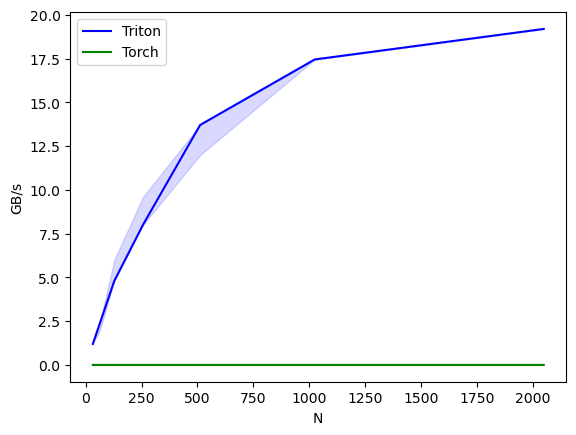

a:
        N     Triton     Torch
0    32.0   1.200000  0.000401
1    64.0   2.400000  0.000416
2   128.0   4.800000  0.000432
3   256.0   8.000000  0.000427
4   512.0  13.714286  0.000419
5  1024.0  17.454545  0.000422
6  2048.0  19.200000  0.000427


In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[16 * 2**i for i in range(1, 8)],
        x_log=False,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="a",
        args={"B": 16},
    )
)
def benchmark(B, N, provider):
    x = th.rand(B, N, 3, device="cuda")
    grid_size = 256

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: hilbert(x, grid_size),
            quantiles=quantiles,
        )
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: point_to_hilbert_distance_3d_depth16_fp32(x, grid_size),
            quantiles=quantiles,
        )

    gbps = lambda ms: (x.nelement() * x.element_size()) * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)